In [106]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, Bidirectional, Dropout, \
LSTM, GlobalMaxPool1D, Input, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

In [70]:
data = pd.read_csv("./train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [3]:
test = pd.read_csv("./test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78035 entries, 0 to 78034
Data columns (total 15 columns):
id                                              78035 non-null object
teacher_id                                      78035 non-null object
teacher_prefix                                  78034 non-null object
school_state                                    78035 non-null object
project_submitted_datetime                      78035 non-null object
project_grade_category                          78035 non-null object
project_subject_categories                      78035 non-null object
project_subject_subcategories                   78035 non-null object
project_title                                   78035 non-null object
project_essay_1                                 78035 non-null object
project_essay_2                                 78035 non-null object
project_essay_3                                 2704 non-null object
project_essay_4                                 2704

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


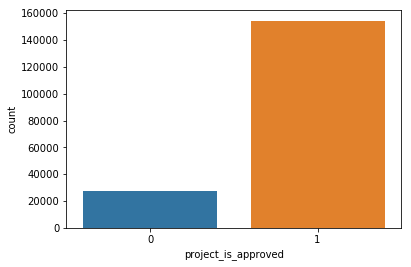

In [4]:
sns.countplot(data.project_is_approved)

In [69]:
data.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_title_proc,teacher_id_approval
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,super sight word centers,1.0
1,p137019,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-08-04 23:49:17,Grades PreK-2,Literacy & Language,Literacy,"Charting, Storing, and Anchoring our Learning",Most of my kindergarten students come from low...,Chart paper is a must have in any kindergarten...,NaN,NaN,My students need 10 ruled chart tablets in ord...,20,1,charting storing and anchoring our learning,1.0
2,p257998,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 20:35:15,Grades PreK-2,Literacy & Language,Literacy,Scaredy Squirrel Superfans!,Most of my kindergarten students come from low...,We read the book Scaredy Squirrel this year an...,NaN,NaN,My students need a Scaredy Squirrel classroom ...,26,1,scaredy squirrel superfans,1.0
3,p184320,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2017-03-01 16:34:51,Grades PreK-2,Literacy & Language,"Literacy, Literature & Writing",Creating a Colorful Kinder,Most of my kindergarten students come from low...,We currently have only a black and white print...,NaN,NaN,My students need one color printer and ink rep...,33,1,creating a colorful kinder,1.0
4,p058409,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2017-01-20 21:52:31,Grades PreK-2,Literacy & Language,"ESL, Literacy",Practicing Reading At Home,Most of my kindergarten students come from low...,Many of my students do not have the luxury of ...,NaN,NaN,My students need book bags and leveled readers...,29,1,practicing reading at home,1.0


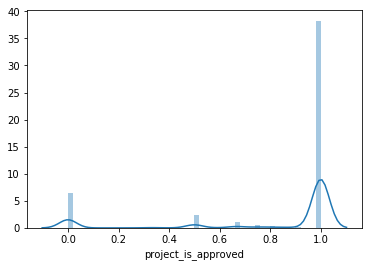

In [71]:
mean_encoding_teacher_id = data.groupby(['teacher_id'])['project_is_approved'].mean()
mean_encoding_teacher_id = mean_encoding_teacher_id.reset_index()
mean_encoding_teacher_id.head()
sns.distplot(mean_encoding_teacher_id.project_is_approved)
mean_encoding_teacher_id.columns = ['teacher_id', 'teacher_id_approval']

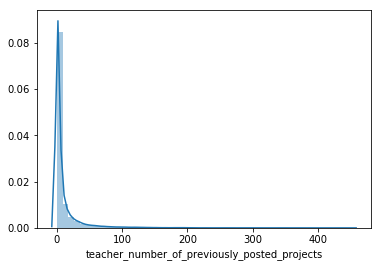

In [101]:
sns.distplot(data.teacher_number_of_previously_posted_projects)

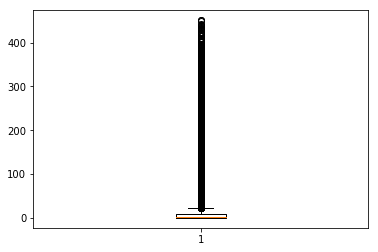

In [128]:
b = plt.boxplot(data.teacher_number_of_previously_posted_projects)
caps = [item.get_ydata()[0] for item in b['caps']]

t_prev = np.clip(data.teacher_number_of_previously_posted_projects,
                                                      a_max = caps[1], a_min = caps[0])

data['teacher_number_of_previously_posted_projects_norm'] = (data.teacher_number_of_previously_posted_projects - min(t_prev))/(max(t_prev) - min(t_prev))

In [73]:
data = data.merge(mean_encoding_teacher_id, on=['teacher_id'])

In [7]:
# punct_remover = str.maketrans('', '', string.punctuation)
punct_remover = str.maketrans(string.punctuation, ' '*len(string.punctuation))
def text_cleanse(text):
    return text.replace("\\r", " ").replace("\\n", " ").replace("\\t", " ").replace("\\","") \
.translate(punct_remover).replace(".","").lower()

In [8]:
data["project_title_proc"] = [text_cleanse(text) for text in data.project_title]

In [9]:
max([len(text) for text in data.project_title_proc])

125

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.project_title_proc)
vocab_size = len(tokenizer.word_index) + 1

In [11]:
enc_docs = tokenizer.texts_to_sequences(data.project_title_proc)

In [12]:
max_length = 125
padded_docs = pad_sequences(enc_docs, maxlen = max_length, padding = 'post')

In [13]:
embeddings_index = dict()
f = open('./glove.6B.300d.txt', encoding="UTF-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [14]:
dims = 300
embedding_matrix = np.zeros((vocab_size, dims))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [75]:
X1.shape

(182080, 2)

In [129]:
inputs = Input(shape=(125,))
inputs1 = Input(shape=(2,))
x = Embedding(vocab_size, dims, weights = [embedding_matrix], input_length = max_length, trainable = False)(inputs)
x = GlobalAveragePooling1D()(x)
x = concatenate([x, inputs1])
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs= [inputs, inputs1], outputs= x)
model.summary()

model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_54 (InputLayer)            (None, 125)           0                                            
____________________________________________________________________________________________________
embedding_28 (Embedding)         (None, 125, 300)      6410700     input_54[0][0]                   
____________________________________________________________________________________________________
global_average_pooling1d_31 (Glo (None, 300)           0           embedding_28[0][0]               
____________________________________________________________________________________________________
input_55 (InputLayer)            (None, 2)             0                                            
___________________________________________________________________________________________

In [245]:
model = Sequential()
e = Embedding(vocab_size, dims, weights = [embedding_matrix], input_length = max_length, trainable = False)
model.add(e)
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
'''model.add(Bidirectional(LSTM(50, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))'''

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 125, 300)          6410700   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                9632      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 6,420,365
Trainable params: 9,665
Non-trainable params: 6,410,700
_________________________________________________________________


In [45]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, data.project_is_approved, 
                                                    test_size = 0.2, random_state = 42)

In [130]:
X1 = np.array(data[['teacher_number_of_previously_posted_projects_norm', 'teacher_id_approval']])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, data.project_is_approved, 
                                                        test_size = 0.2, random_state = 42)

In [131]:
train_performance = model.fit([X_train, X_train1], y_train, batch_size=64, 
                              epochs=5, validation_data=([X_test, X_test1], y_test))

Train on 145664 samples, validate on 36416 samples
Epoch 1/5
145664/145664 [==============================] - 13s - loss: 0.4272 - acc: 0.8478 - val_loss: 0.4203 - val_acc: 0.8469

In [132]:
preds = model.predict([X_test, X_test1])
print(auc(y_test, preds, reorder=True))

0.780898571014


In [51]:
test["project_title_proc"] = [text_cleanse(text) for text in test.project_title]
enc_test_docs = tokenizer.texts_to_sequences(test.project_title_proc)
padded_test_docs = pad_sequences(enc_test_docs, maxlen = max_length, padding = 'post')

In [52]:
preds = model.predict(padded_test_docs)

In [53]:
test["project_is_approved"] = preds

In [54]:
submission = pd.read_csv("./sample_submission.csv")

In [55]:
submission.head()

,id,project_is_approved
0,p233245,0.847682
1,p096795,0.847682
2,p236235,0.847682
3,p233680,0.847682
4,p171879,0.847682


In [56]:
submission = test[["id", "project_is_approved"]]
submission.head()

,id,project_is_approved
0,p233245,0.827939
1,p096795,0.878627
2,p236235,0.811892
3,p233680,0.839038
4,p171879,0.882446


In [57]:
submission.to_csv("./submission.csv", index=False)